# Playground Series - Season 3, Episode 11

## Load Competition Items

In [3]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# specify path and load data
data_path = Path('../data')
test_df = pd.read_csv(data_path/'test.csv')
train_df = pd.read_csv(data_path/'train.csv')
samp_submission = pd.read_csv(data_path/'sample_submission.csv')

## Data Understanding

In [5]:
display(train_df.head(3))
display(train_df.tail(3))

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51


,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
360333,360333,10.74,3.0,0.0,0.0,2.0,11.3,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,360334,11.04,3.0,1.0,0.0,3.0,10.2,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72
360335,360335,5.30,2.0,2.0,0.0,2.0,10.8,0.0,0.0,21.0,33858.0,1.0,0.0,1.0,1.0,1.0,122.47


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

`cost` is the target variable.

### Variable Distributions

<Axes: xlabel='cost', ylabel='Count'>

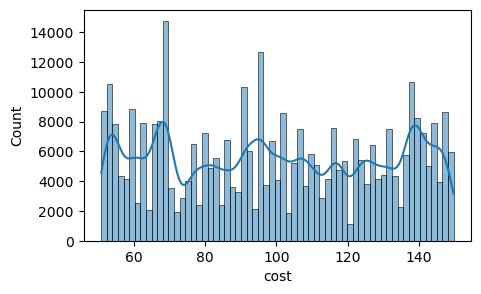

In [7]:
# target 
plt.figure(figsize=(5,3))
sns.histplot(x=train_df.cost,kde=True)

In [8]:
# calc number of features to display
len(train_df.drop(['cost', 'id'], axis=1).columns)

15

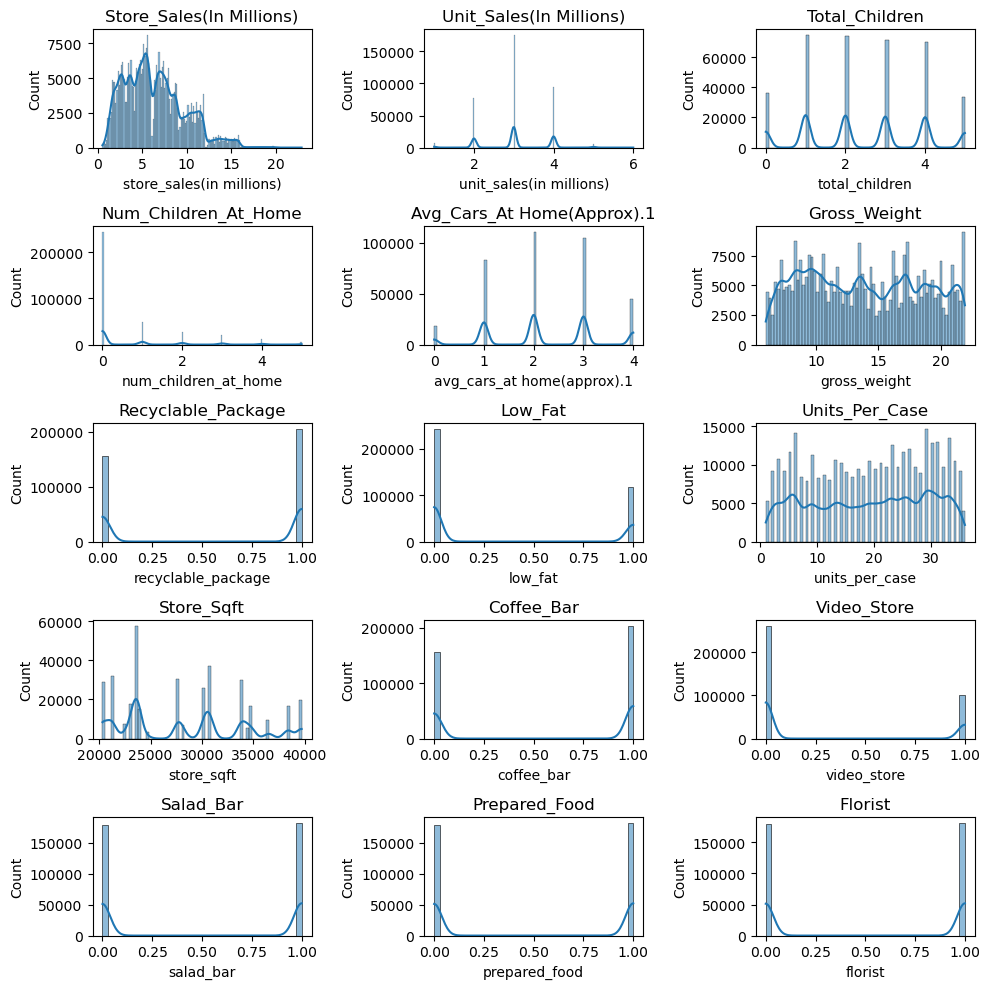

In [18]:
# set up subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10))
feat_cols = train_df.drop(['cost', 'id'], axis=1).columns

for feat, ax in zip(feat_cols, axes.flatten()):
    sns.histplot(train_df[feat], kde=True, bins='auto', ax=ax)
    ax.set_title(f'{feat.title()}')
    ax.set_xlabel(feat)
plt.tight_layout()
plt.show()

In [19]:
# identify continuous and categorical variables
cat_feats = ['unit_sales(in millions)', 'total_children', 'num_children_at_home',
             'avg_cars_at_home(approx).1', 'recyclable_package', 'low_fat',
             'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
cont_feats = ['store_sales(in millions)', 'gross_weight', 'units_per_case', 'store_sqft']